# Resumen Integrado de Boosting y AdaBoost

Boosting es un enfoque de **aprendizaje de máquina** que crea un clasificador fuerte a partir de una combinación de clasificadores débiles. Se basa en la idea de mejorar iterativamente clasificadores que son solo ligeramente mejores que adivinar al azar. El algoritmo **AdaBoost.M1**, introducido por Freund y Schapire, es un enfoque particular de boosting diseñado para problemas de clasificación binaria.

AdaBoost se diferencia de otras técnicas de ensamble como el bagging en que ajusta adaptativamente los clasificadores débiles en secuencia, enfocándose más en los casos que fueron clasificados incorrectamente en iteraciones anteriores. El objetivo es que cada nuevo clasificador se concentre en los errores del anterior, asignando más peso a las observaciones más difíciles de clasificar.

La eficacia del AdaBoost se ilustra en el ejemplo proporcionado, donde incluso un clasificador muy simple, como un "stump", puede reducir significativamente su tasa de error a través de iteraciones de boosting. La grdel libro indica quea cómo, a medida que aumenta el número de iteraciones de boosting, la tasa de error de prueba disminuye, lo que indica una mejora en la precisión del clasificador combinado.

## Explicación Detallada del Algoritmo 10.1 AdaBoost.M1

El Algoritmo 10.1 **AdaBoost.M1** funciona de la siguiente manera:

1. **Inicialización**: Seeasigna unlp$so inicia$ `w_i = 1/N` a cada una de las N observaciones en el conjunto de entrenamiento, lo que significa que inicialmente todas las observaciones tienen la misma importancia.

2. **Iteraciones de Boosting**: Se realizan M iteraciones para construir M clasificadores débiles. Cada iteración consiste en los siguientes pasos:
   - **Ajuste del Clasificador**: Se entrena u$ clasi$icador `G_m(x)` usando los pesos actuales de las observaciones.
   - **Cálculo del Error**: Se calcula la tasa de error ponderada `err_m`, que es la suma de los pesos de las observaciones mal clasificadas dividida por la suma de todos los pesos.
   - **Determinación del Peso del Clasificador**: Se calcula el peso `α_m` del clasificador basado en su tasa de error; clasificadores con errores menores reciben un mayor peso.
   - **Actualización de Pesos de Observaciones**: Se actualizan los pesos de las observaciones; los pesos de las observaciones mal clasificadas son aumentados, lo que les dará más importancia en la siguiente iteración del entrenamiento.

3. **Construcción del Clasificador Final**: El clasificador combinado final `G(x)` se obtiene tomando el signo de la suma ponderada de las predicciones de todos los clasificadores débiles con sus respectivos pesos `α_m`. Esto significa que cada clasificador vota para la clasificación final, y el voto de cada uno está ponderado por su eficacia percibida.

El algoritmo asegura que los clasificadores sucesivos se enfoquen más en los casos que fueron difíciles de clasificar correctamente en pasos anteriores, lo que lleva a una mejora en la precisión del modelo general. Esta técnica ha demostrado ser particularmente eficaz cuando se utilizan árboles de decisión como clasificadores base, a menudo resultando en mejoras ds en la precisión.





# Usando funciones propias.

In [12]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Definimos una función para simular un clasificador débil, en este caso un "stump".
def weak_classifier(X, y, weights):
    # Se crea un objeto de árbol de decisión con profundidad máxima de 1, conocido como "stump".
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    # Se entrena el "stump" con los datos y pesos actuales de las muestras.
    stump.fit(X, y, sample_weight=weights)
    # Se generan predicciones para las muestras usando el "stump".
    predictions = stump.predict(X)
    # Obtenemos el índice de la característica y el umbral utilizados por el "stump".
    # Estos no se utilizan en el AdaBoost, pero se devuelven por consistencia.
    feature_index = stump.tree_.feature[0]
    threshold = stump.tree_.threshold[0]
    return predictions, feature_index, threshold

# Función para calcular el error ponderado de las predicciones.
def compute_error(y, predictions, weights):
    # Se calcula el error como la suma ponderada de las clasificaciones incorrectas.
    return weights.dot(y != predictions) / weights.sum()

# Función para calcular el peso del clasificador en la combinación final.
def compute_alpha(error):
    # Se utiliza la fórmula de AdaBoost para calcular alpha a partir del error.
    return np.log((1 - error) / error)

# Función para actualizar los pesos de las muestras.
def update_weights(weights, alpha, y, predictions):
    # Se aumentan los pesos de las muestras mal clasificadas y se disminuyen los de las bien clasificadas.
    return weights * np.exp(alpha * (y != predictions))

# Implementación del algoritmo AdaBoost.M1.
def ada_boost_m1(X, y, M):
    N = X.shape[0]
    # Inicializamos los pesos de todas las muestras igualmente.
    weights = np.ones(N) / N
    # Listas para almacenar los clasificadores, sus pesos y los errores.
    classifiers = []
    alphas = []
    errors = []

    # Bucle principal de AdaBoost.
    for m in range(M):
        # Se entrena un clasificador débil y se obtiene su error.
        predictions, feature_index, threshold = weak_classifier(X, y, weights)
        err_m = compute_error(y, predictions, weights)
        # Se almacena el error de esta iteración.
        errors.append(err_m)
        # Se calcula el peso del clasificador basado en el error.
        alpha_m = compute_alpha(err_m)
        # Se actualizan los pesos de las muestras para la siguiente iteración.
        weights = update_weights(weights, alpha_m, y, predictions)
        # Se almacenan el clasificador y su peso.
        classifiers.append((feature_index, threshold))
        alphas.append(alpha_m)

    # Se define la función de clasificación final combinada.
    def G(x):
        final_prediction = np.zeros(x.shape[0])
        # Se suma el efecto de cada clasificador débil ponderado por su alfa.
        for alpha, (feature_index, threshold) in zip(alphas, classifiers):
            prediction = np.ones(x.shape[0])
            prediction[x[:, feature_index] < threshold] = -1
            final_prediction += alpha * prediction
        # Se devuelve la predicción combinada.
        return np.sign(final_prediction)

    # La función devuelve el clasificador combinado y la lista de errores.
    return G, errors

In [21]:
from scipy.stats import chi2

# Reestablecemos la semilla para reproducibilidad
np.random.seed(42)

n_samples = 2000  # Número de muestras de entrenamiento
n_test_samples = 10000  # Número de muestras de prueba
n_features = 10   # Número de características (X1,...,X10)

# Generamos los datos simulados: X1,...,X10 independientes y siguiendo una distribución gaussiana estándar
X_simulated = np.random.randn(n_samples + n_test_samples, n_features)

# Calculamos la suma de cuadrados de las características para cada muestra
sum_of_squares = np.sum(X_simulated**2, axis=1)

# Definimos el umbral usando la mediana de una variable aleatoria chi-cuadrado con 10 grados de libertad
chi2_threshold = chi2.ppf(0.5, df=n_features)

# Creamos la variable objetivo Y basada en el umbral del chi-cuadrado
Y_simulated = np.where(sum_of_squares > chi2_threshold, 1, -1)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train_simulated, X_test_simulated = X_simulated[:n_samples], X_simulated[n_samples:]
Y_train_simulated, Y_test_simulated = Y_simulated[:n_samples], Y_simulated[n_samples:]

# Verificamos la distribución de la variable objetivo en el conjunto de entrenamiento
np.mean(Y_train_simulated == 1), np.mean(Y_train_simulated == -1)

(0.4935, 0.5065)

Hemos creado características independientes \(X_1, \ldots, X_{10}\) que siguen una distribución gaussiana estándar. Luego definimos una variable objetivo \(Y\) tal que \(Y = 1\) si la suma de los cuadrados de las características excede el umbral definido por la mediana de una variable aleatoria chi-cuadrado con 10 grados de libertad, y \(Y = -1\) de lo contrario.

El conjunto de datos de entrenamiento tiene una distribución casi equilibrada de las clases con un \(49.35\%\) de las muestras pertenecientes a la clase 1 y un \(50.65\%\) a la clase -co.


In [22]:
M = 400

# Reentrenamos AdaBoost.M1 usando el nuevo clasificador débil
G, errors = ada_boost_m1(X_train_simulated, Y_train_simulated, M)

# Evaluamos el rendimiento en el conjunto de prueba con el nuevo clasificador
final_predictions = G(X_test_simulated)
test_error = np.mean(final_predictions != Y_test_simulated)

test_error, errors[-1]  # Mostrar el error de prueba final y el último error de entrenamiento

(0.4429, 0.4848771903893841)

# Utilizando librerias.

In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Parámetros para la simulación
n_samples = 2000  # Número de muestras de entrenamiento
n_features = 10   # Número de características (X1,...,X10)
n_test_samples = 10000  # Número de muestras de prueba

# Generar datos simulados
X, Y = make_classification(n_samples=n_samples + n_test_samples, n_features=n_features, 
                           n_informative=n_features, n_redundant=0, 
                           n_clusters_per_class=1, flip_y=0, random_state=42)

# Definir la variable objetivo Y usando la regla dada
chi2_threshold = np.percentile(np.sum(X**2, axis=1), 50)
Y = np.where(np.sum(X**2, axis=1) > chi2_threshold, 1, -1)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=n_test_samples, random_state=42)

# Inicializar el clasificador AdaBoost con un "stump" como clasificador base
stump = DecisionTreeClassifier(max_depth=1, random_state=42) # Un "stump" es un árbol de decisión de profundidad 1
ada_clf = AdaBoostClassifier(estimator=stump, n_estimators=400, random_state=42)


# Entrenar el clasificador AdaBoost
ada_clf.fit(X_train, Y_train)

# Calcular la precisión en el conjunto de prueba después de cada iteración de boosting
test_errors = []

for test_predict in ada_clf.staged_predict(X_test):
    test_errors.append(1 - accuracy_score(Y_test, test_predict))

# Mostrar los primeros y últimos 10 errores de prueba
test_errors[:10], test_errors[-10:]

([0.4254,
  0.35040000000000004,
  0.29710000000000003,
  0.28490000000000004,
  0.27070000000000005,
  0.25439999999999996,
  0.26170000000000004,
  0.26249999999999996,
  0.22699999999999998,
  0.21860000000000002],
 [0.04749999999999999,
  0.04749999999999999,
  0.04710000000000003,
  0.046699999999999964,
  0.046699999999999964,
  0.04710000000000003,
  0.046599999999999975,
  0.0464,
  0.04590000000000005,
  0.046499999999999986])

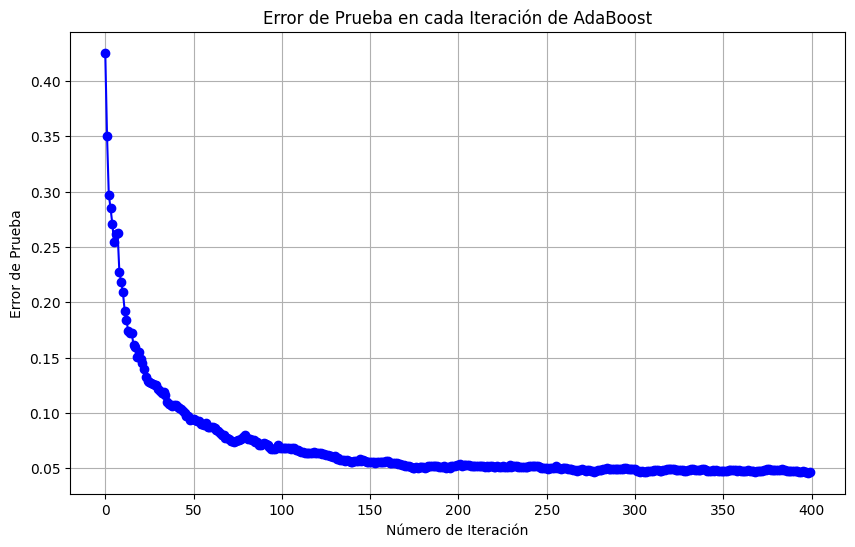

In [23]:
import matplotlib.pyplot as plt

# Crear el plot
plt.figure(figsize=(10, 6))
plt.plot(test_errors, marker='o', linestyle='-', color='blue')
plt.title('Error de Prueba en cada Iteración de AdaBoost')
plt.xlabel('Número de Iteración')
plt.ylabel('Error de Prueba')
plt.grid(True)
plt.show()